# Imports

In [232]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import numpy as np
from matplotlib import pyplot as plt
import camb
from camb import model, initialpower
import bayesflow as bf

import seaborn as sns
import time
import pickle
import tensorflow as tf


from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

print('Using CAMB %s installed at %s' % (camb.__version__, os.path.dirname(camb.__file__)))
# make sure the version and path is what you expect

Using CAMB 1.6.1 installed at C:\Users\rahul\AppData\Local\Programs\Python\Python311\Lib\site-packages\camb


# Data generating process

## Definitions

In [233]:
def generate_logPK(H0, Omega_m, n_s, k_vals=None, noise_level=0.2, seed=None):
    """
    Generate noisy matter power spectrum P(k) from given cosmological parameters.

    Parameters:
        H0 (float): Hubble constant (km/s/Mpc)
        Omega_m (float): total matter density (Ω_m)
        n_s (float): spectral index
        k_vals (np.array or None): k values (1/Mpc). Default: logspace from 1e-3 to ~3.16
        noise_level (float): relative Gaussian noise (e.g., 0.05 = 5%)

    Returns:
        noisy_P_k (np.array): noisy matter power spectrum at redshift z=0
    """
    # Default k range: safe values for CAMB
    if k_vals is None:
        k_vals = np.logspace(-4, 1, 1024)


    ## To calculate the physical densities from the densities 
    # Baryon density
    Omega_b = 0.05
    
    # Cold dark matter density
    Omega_c = Omega_m - Omega_b

    # dimensionless Hubble parameter
    h = H0 / 100

    
    # physical densities
    ombh2 = Omega_b * h**2
    omch2 = Omega_c * h**2


    # Setup CAMB
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
    pars.InitPower.set_params(ns=n_s)
    pars.set_matter_power(redshifts=[0], kmax=max(k_vals))

    # Run CAMB and get P(k)
    PK = camb.get_matter_power_interpolator(pars, nonlinear=False, kmax=max(k_vals))
    P_k = PK.P(0, k_vals)

     # Conditional RNG
    if seed is not None:
        rng = np.random.default_rng(seed)  # reproducible
    else:
        rng = np.random.default_rng()      # fresh random

    # Add heteroscedastic Gaussian noise.
    # Noise is added according to the scale of P_k which make more realistic observations
    # noise = rng.normal(0, noise_level * P_k)
    # P_k_noisy = P_k + noise

    # Step 2: Apply log10 to each output
    log_k = np.log10(k_vals)
    #log_P_k_noisy = np.log10(P_k_noisy)
    
    
    
    
    log_P_k_clean = np.log10(P_k)

    log_noise = rng.normal(0, noise_level, len(P_k))
    log_P_k_noisy = log_P_k_clean + log_noise
    
    # shape adjustments
    log_k = log_k.reshape(-1, 1)
    log_P_k_clean = log_P_k_clean.reshape(-1, 1)
    log_P_k_noisy = log_P_k_noisy.reshape(-1, 1)

    return {     
        'log_k': log_k,
        'log_P_k_noisy': log_P_k_noisy,
        'log_P_k_clean': log_P_k_clean  
    }

## Generating noisy observations

$\theta^*$, True parameter from Planck 2018

In [234]:
# Define the true cosmological parameters
theta_star = {
    'H0': 67.4,
    'Omega_m': 0.315,
    'n_s': 0.965
}

In [235]:
# Generate the noisy power spectrum using theta_star
Log_Pk_obs = generate_logPK(
    H0=theta_star['H0'],
    Omega_m=theta_star['Omega_m'],
    n_s=theta_star['n_s'],
    noise_level=0.2,   # 20% relative Gaussian noise
    seed=42            # Optional, for reproducibility
)

## Visualization

P(k) vs k_vals

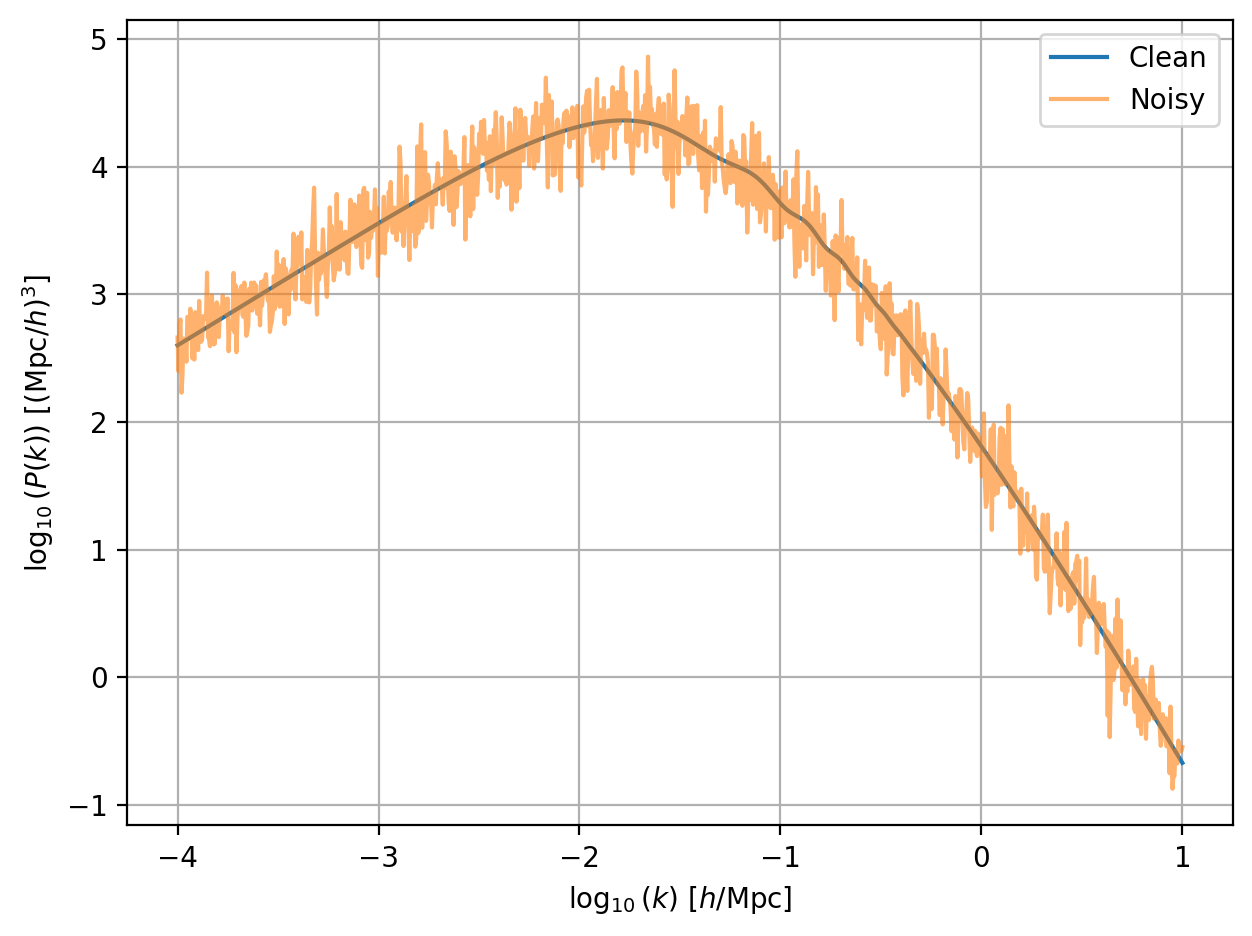

In [236]:
plt.plot(Log_Pk_obs['log_k'], Log_Pk_obs['log_P_k_clean'], label='Clean')
plt.plot(Log_Pk_obs['log_k'], Log_Pk_obs['log_P_k_noisy'], label='Noisy', alpha=0.6)
plt.xlabel(r'$\log_{10}(k)\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\log_{10}(P(k))\ [(\mathrm{Mpc}/h)^3]$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

$f(P\_k))$, probability density of power spectrum

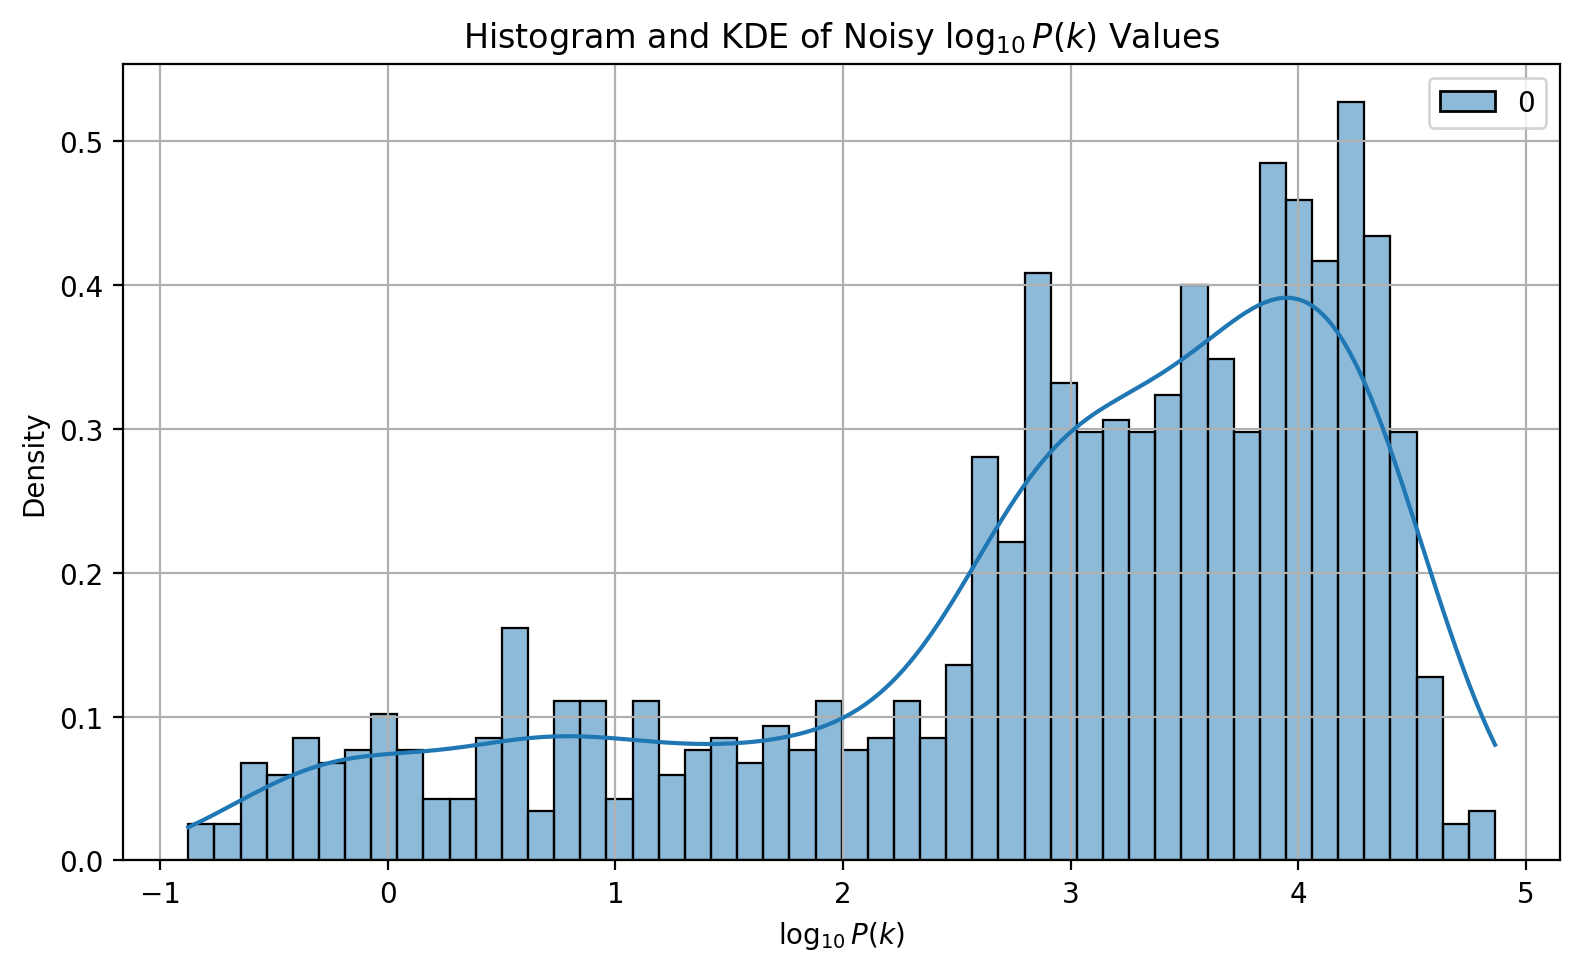

In [237]:

# Plot histogram and KDE
plt.figure(figsize=(8, 5))
sns.histplot(Log_Pk_obs['log_P_k_noisy'], bins=50, kde=True, stat="density", color='skyblue', edgecolor='black')

plt.title('Histogram and KDE of Noisy $\log_{10} P(k)$ Values')
plt.xlabel(r'$\log_{10} P(k)$')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()


# Bayes Flow

Prior: $(\theta^{(s)}) \sim P(\theta)$

In [238]:
def prior(seed=None):
    rng = np.random.default_rng(seed)

    H0 = rng.uniform(30, 100)
    Omega_m = rng.uniform(0.1, 0.6)
    n_s = rng.uniform(0.8, 1.5)

    return {
        'H0': H0,
        'Omega_m': Omega_m,
        'n_s': n_s
    }


# Prior Plots

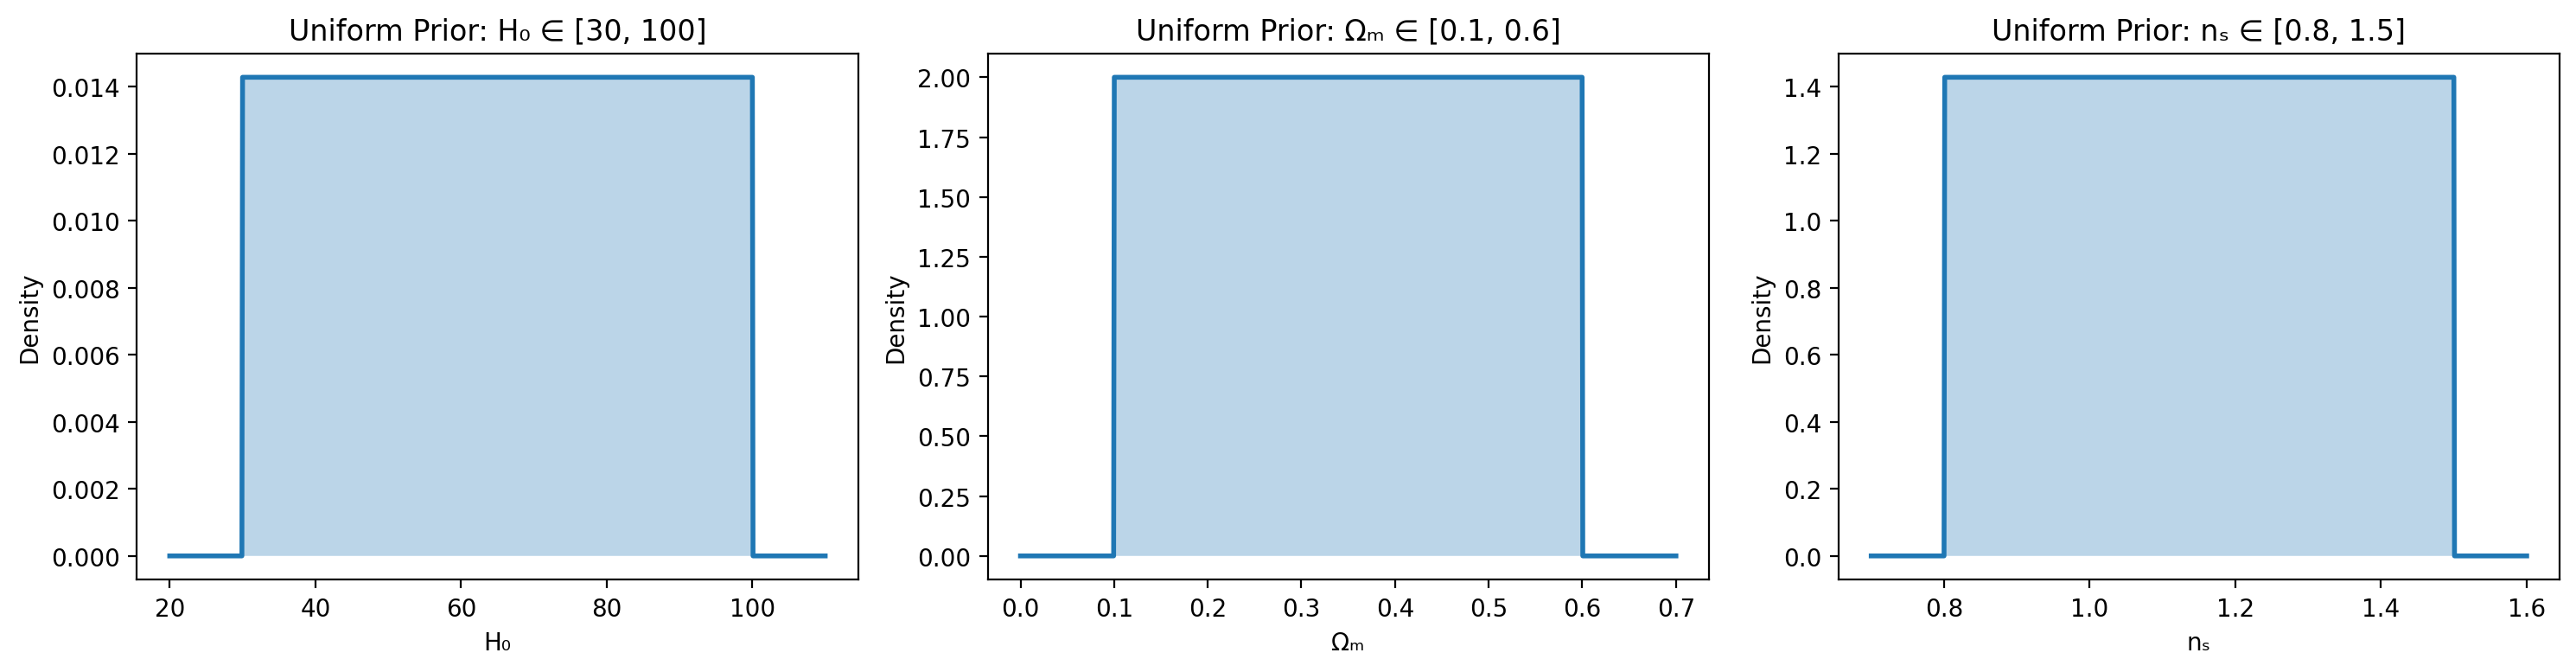

In [239]:

# Parameter ranges
H0_range = (30, 100)
Om_range = (0.1, 0.6)
ns_range = (0.8, 1.5)

# Define x values
x_H0 = np.linspace(20, 110, 1000)
x_Om = np.linspace(0, 0.7, 1000)
x_ns = np.linspace(0.7, 1.6, 1000)

# Uniform densities
def uniform_density(x, a, b):
    return np.where((x >= a) & (x <= b), 1 / (b - a), 0)

# Compute densities
y_H0 = uniform_density(x_H0, *H0_range)
y_Om = uniform_density(x_Om, *Om_range)
y_ns = uniform_density(x_ns, *ns_range)

# Plotting
plt.figure(figsize=(15, 4))

# H0
plt.subplot(1, 3, 1)
plt.plot(x_H0, y_H0, lw=2)
plt.fill_between(x_H0, 0, y_H0, alpha=0.3)
plt.title('Uniform Prior: H₀ ∈ [30, 100]')
plt.xlabel('H₀')
plt.ylabel('Density')

# Ωm
plt.subplot(1, 3, 2)
plt.plot(x_Om, y_Om, lw=2)
plt.fill_between(x_Om, 0, y_Om, alpha=0.3)
plt.title('Uniform Prior: Ωₘ ∈ [0.1, 0.6]')
plt.xlabel('Ωₘ')
plt.ylabel('Density')

# ns
plt.subplot(1, 3, 3)
plt.plot(x_ns, y_ns, lw=2)
plt.fill_between(x_ns, 0, y_ns, alpha=0.3)
plt.title('Uniform Prior: nₛ ∈ [0.8, 1.5]')
plt.xlabel('nₛ')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


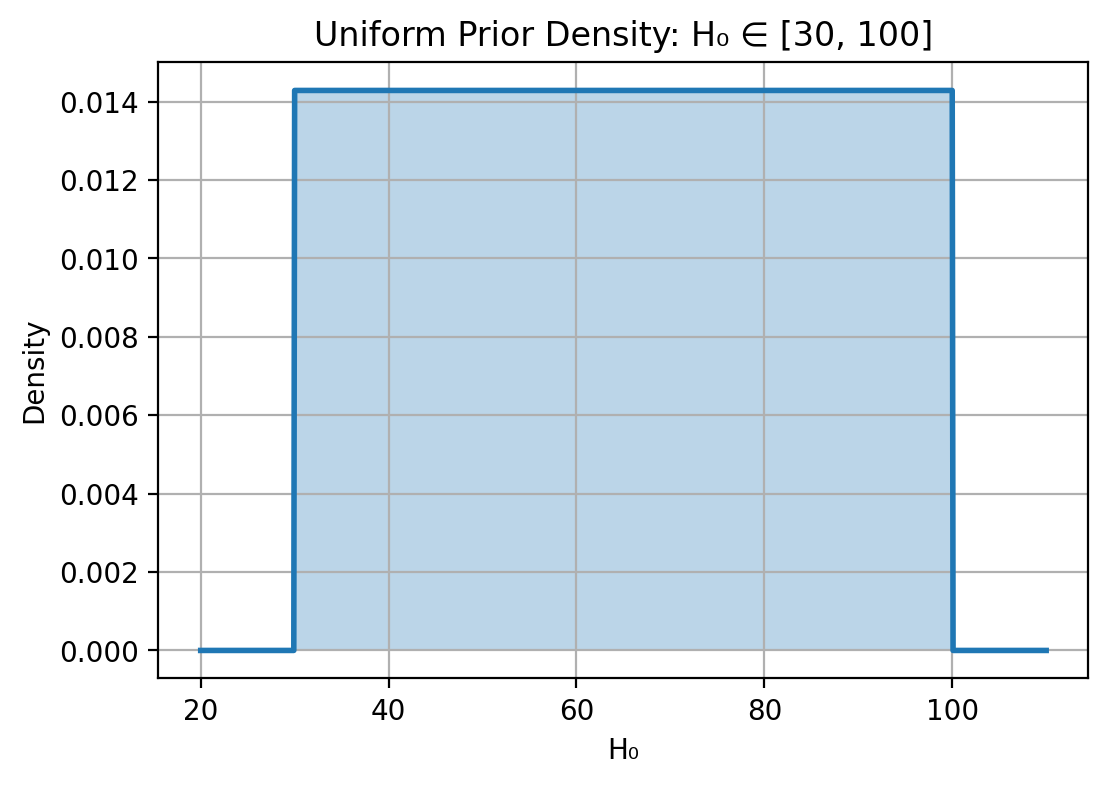

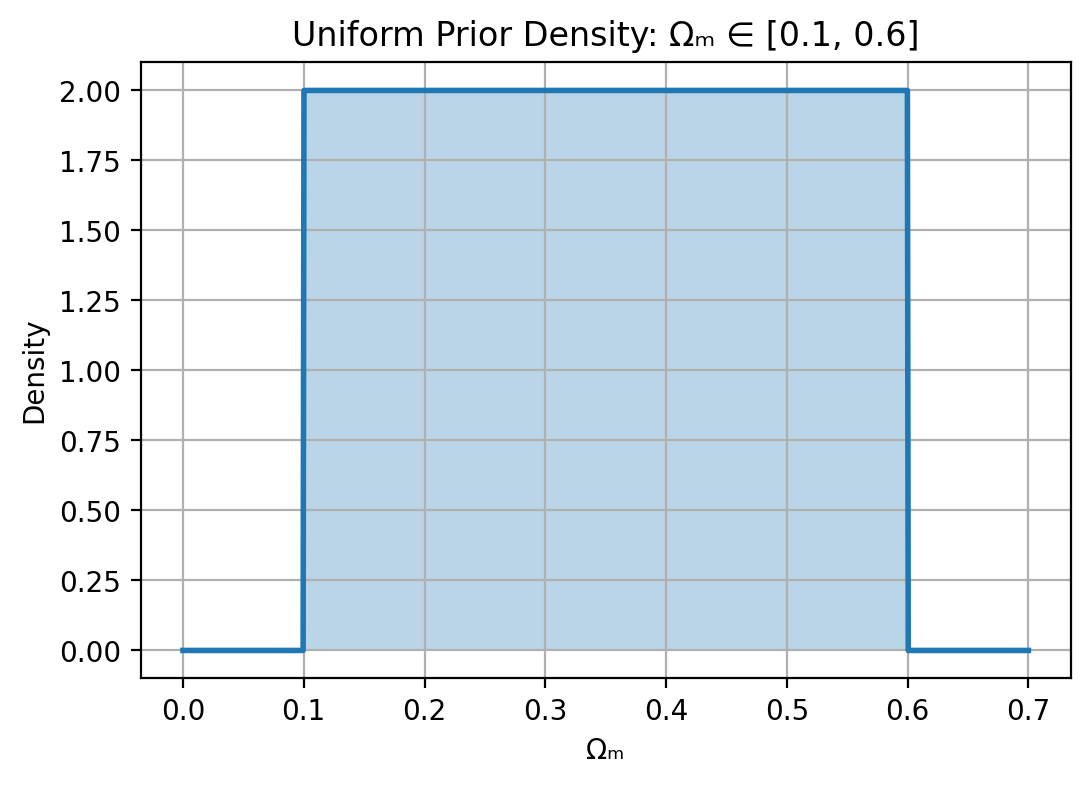

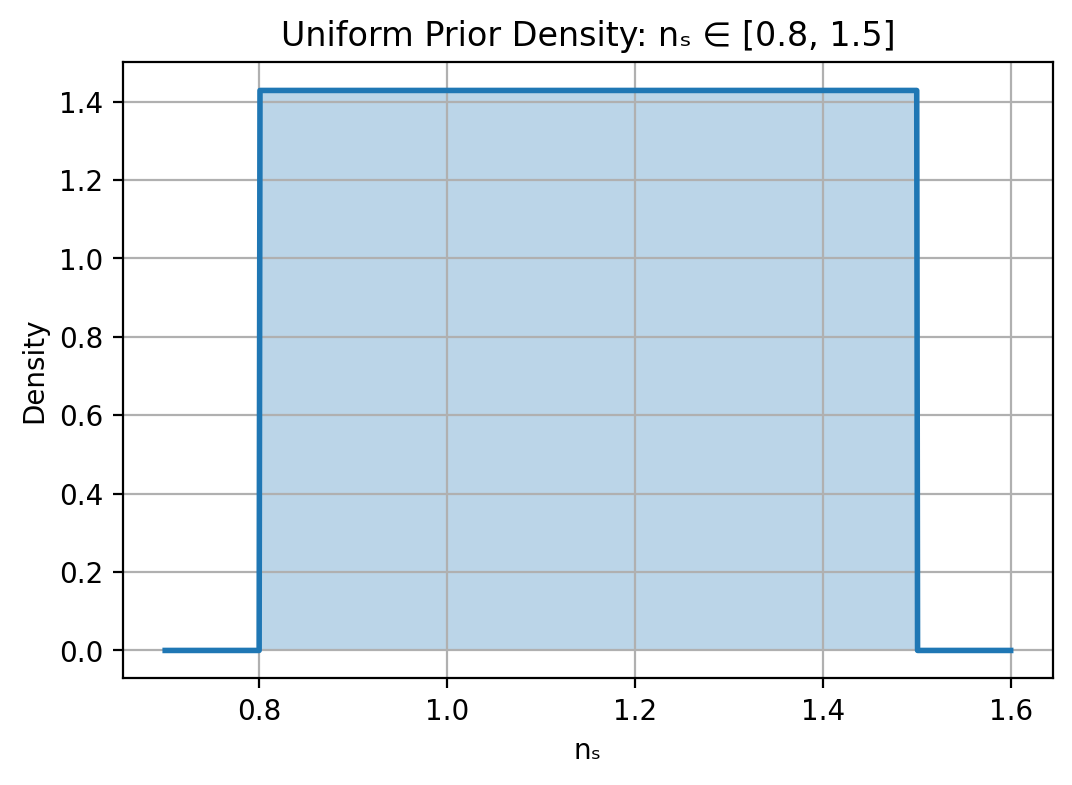

In [240]:

# Uniform density function
def uniform_density(x, a, b):
    return np.where((x >= a) & (x <= b), 1 / (b - a), 0)

# Plot 1: Hubble constant H0
x_H0 = np.linspace(20, 110, 1000)
y_H0 = uniform_density(x_H0, 30, 100)

plt.figure(figsize=(6, 4))
plt.plot(x_H0, y_H0, lw=2)
plt.fill_between(x_H0, 0, y_H0, alpha=0.3)
plt.title('Uniform Prior Density: H₀ ∈ [30, 100]')
plt.xlabel('H₀')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot 2: Matter density Ωm
x_Om = np.linspace(0, 0.7, 1000)
y_Om = uniform_density(x_Om, 0.1, 0.6)

plt.figure(figsize=(6, 4))
plt.plot(x_Om, y_Om, lw=2)
plt.fill_between(x_Om, 0, y_Om, alpha=0.3)
plt.title('Uniform Prior Density: Ωₘ ∈ [0.1, 0.6]')
plt.xlabel('Ωₘ')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot 3: Spectral index ns
x_ns = np.linspace(0.7, 1.6, 1000)
y_ns = uniform_density(x_ns, 0.8, 1.5)

plt.figure(figsize=(6, 4))
plt.plot(x_ns, y_ns, lw=2)
plt.fill_between(x_ns, 0, y_ns, alpha=0.3)
plt.title('Uniform Prior Density: nₛ ∈ [0.8, 1.5]')
plt.xlabel('nₛ')
plt.ylabel('Density')
plt.grid(True)
plt.show()


Likelihood: $(y^{(s)}) \sim P(y | \theta)$
The same function but with just one output of length of k_vals

In [241]:
def likelihood(H0, Omega_m, n_s, k_vals=None, noise_level=0.2, seed=None, n = 256):
    """
    Generate log10 of the noisy matter power spectrum P(k) from given cosmological parameters.

    Parameters:
        H0 (float): Hubble constant (km/s/Mpc)
        Omega_m (float): total matter density (Ω_m)
        n_s (float): spectral index
        k_vals (np.array or None): k values (1/Mpc). Default: logspace from 1e-4 to 10
        noise_level (float): standard deviation of additive Gaussian noise in log space
        seed (int or None): for reproducibility

    Returns:
        log_P_k_noisy (np.array): noisy log10 power spectrum at z = 0
    """

    if k_vals is None:
        k_vals = np.logspace(-4, 1, n)

    Omega_b = 0.05
    Omega_c = Omega_m - Omega_b
    h = H0 / 100
    ombh2 = Omega_b * h**2
    omch2 = Omega_c * h**2

    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
    pars.InitPower.set_params(ns=n_s)
    pars.set_matter_power(redshifts=[0], kmax=max(k_vals))

    PK = camb.get_matter_power_interpolator(pars, nonlinear=False, kmax=max(k_vals))
    P_k = PK.P(0, k_vals)

    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    log_k = np.log10(k_vals)
    log_P_k_clean = np.log10(P_k)
    log_noise = rng.normal(0, noise_level, len(P_k))
    log_P_k_noisy = log_P_k_clean + log_noise


    # shape adjustments
    log_k = log_k.reshape(-1, 1)
    log_P_k_clean = log_P_k_clean.reshape(-1, 1)
    log_P_k_noisy = log_P_k_noisy.reshape(-1, 1)

    return {
        'log_P_k_noisy': log_P_k_noisy
    }

### Testing Prior and Likelihood

In [242]:
theta_test = prior()
print(theta_test)

{'H0': 83.21344711812492, 'Omega_m': 0.1661933556477069, 'n_s': 0.8202506417627783}


In [243]:
# Generate the noisy power spectrum using theta_star
Log_Pk_test = likelihood(
    H0=theta_test['H0'],
    Omega_m=theta_test['Omega_m'],
    n_s=theta_test['n_s'],
    noise_level=0.2,   # 20% relative Gaussian noise
    n = 512
)

In [244]:
Log_Pk_test.keys()

dict_keys(['log_P_k_noisy'])

In [245]:
Log_Pk_test['log_P_k_noisy'].shape

(512, 1)

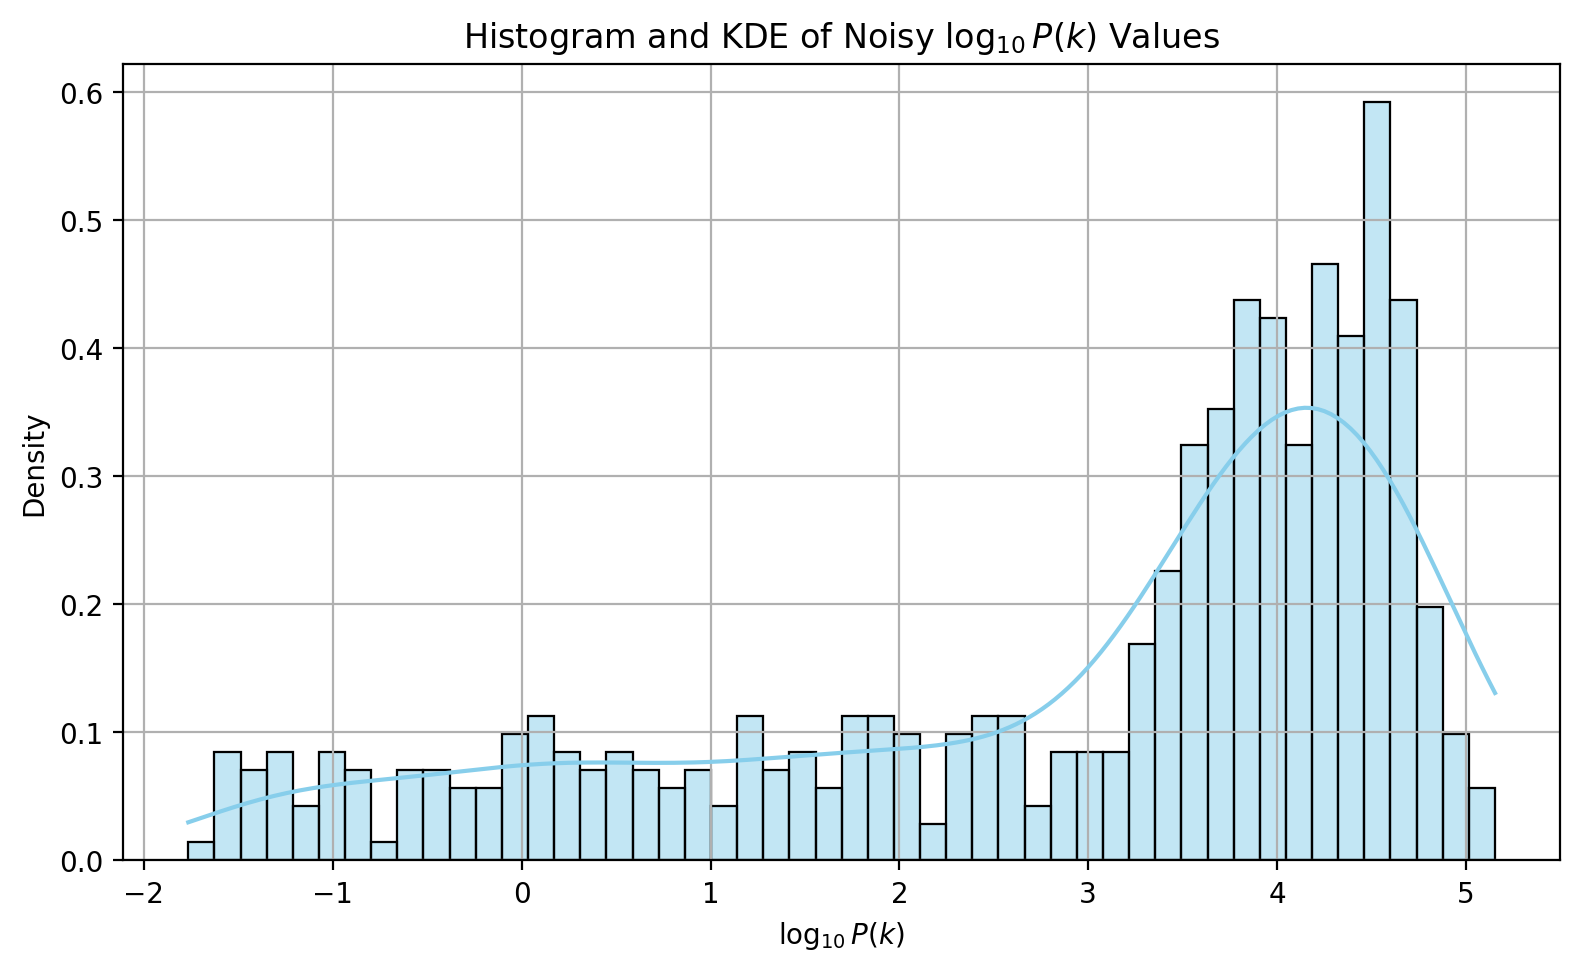

In [246]:
# Plot histogram and KDE for log10(P(k))
plt.figure(figsize=(8, 5))
sns.histplot(Log_Pk_test['log_P_k_noisy'].flatten(), bins=50, kde=True, stat="density", color='skyblue', edgecolor='black')

plt.title('Histogram and KDE of Noisy $\log_{10} P(k)$ Values')
plt.xlabel(r'$\log_{10} P(k)$')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()


# --------------------------  Bayes Flow  --------------------------------------

### Sample from the Joint Distribution $(\theta^{(s)}, y^{(s)}) \sim P(\theta, y)$

### Simulator

In [247]:
simulator = bf.make_simulator([prior, likelihood])

In [248]:
#simulator.sample(2)

###  Adapter 

adapter = (
    bf.Adapter()
    .concatenate(["H0", "Omega_m", "n_s"], into="inference_variables")
    .rename("log_P_k_noisy", "summary_variables")
)

In [249]:
adapter_std = (
    bf.Adapter()
    .concatenate(["H0", "Omega_m", "n_s"], into="inference_variables")
    .rename("log_P_k_noisy", "summary_variables")
    .standardize("summary_variables")
)

### Summary Networks

In [250]:
# 1) Deep
summary_network_Deep = bf.networks.DeepSet()

In [251]:
# 2) Set Trans
summary_network_Set_Trans = bf.networks.SetTransformer()

In [252]:
# 3) TS
summary_network_TS = bf.networks.TimeSeriesTransformer()

Summary network for CNN

In [253]:

class CNNSummaryNet(tf.keras.Model):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.latent_dim = latent_dim
        self.conv1 = tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')
        self.pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)
        self.conv2 = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')
        self.pool2 = tf.keras.layers.MaxPooling1D(pool_size=2)
        self.conv3 = tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')
        self.global_pool = tf.keras.layers.GlobalAveragePooling1D()
        self.dense = tf.keras.layers.Dense(latent_dim, activation='relu')

    def build(self, input_shape):
        # Build layers dynamically (important for BayesFlow)
        dummy_input = tf.zeros(input_shape)
        self.call(dummy_input)
        super().build(input_shape)

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.global_pool(x)
        return self.dense(x)

    def compute_metrics(self, summary_variables, stage=None):
        outputs = self(summary_variables)
        return {"outputs": outputs}

    def compute_output_shape(self, input_shape):
        # Ensure input_shape is a tuple like (batch_size, sequence_length, channels)
        batch_size = input_shape[0] if isinstance(input_shape, tuple) else None
        return (batch_size, self.latent_dim)

In [254]:
# 4) CNN
summary_network_CNN = CNNSummaryNet(latent_dim=20)

# (A) Affine - Coupling Inference Networks

In [255]:
# affine coupling
inference_network_affine = bf.networks.CouplingFlow()

### 1) Affine + Deep

In [256]:
workflow_affine_Deep = bf.BasicWorkflow(
     inference_network=inference_network_affine,
     summary_network=summary_network_Deep,
     adapter=adapter_std,
     simulator=simulator,
    standardize=["inference_variables", "summary_variables"]
)

### Simulating Datasets for 
1) Training
2) Validation
3) Test

In [257]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Timing training data sampling
start_time = time.time()
training_data = workflow_affine_TS.simulate(10000)
training_duration = time.time() - start_time
print(f"Training data simulation took {training_duration:.2f} seconds.")

with open("training_data.pkl", "wb") as f:
    pickle.dump(training_data, f)

In [265]:
with open("training_data.pkl", "rb") as f:
    training_data = pickle.load(f)

    print(training_data.keys())  # Should match original keys

dict_keys(['H0', 'Omega_m', 'n_s', 'log_P_k_noisy'])


# Timing validation data sampling
start_time = time.time()
validation_data = workflow_affine_TS.simulate(1000)
validation_duration = time.time() - start_time
print(f"Validation data simulation took {validation_duration:.2f} seconds.")

# Save validation data
with open("validation_data.pkl", "wb") as f:
    pickle.dump(validation_data, f)

In [261]:
# Load validation data
with open("validation_data.pkl", "rb") as f:
    validation_data = pickle.load(f)

print(validation_data.keys())

dict_keys(['H0', 'Omega_m', 'n_s', 'log_P_k_noisy'])


# Timing test data sampling
start_time = time.time()
test_data = workflow_affine_TS.simulate(1000)
test_duration = time.time() - start_time
print(f"Test data simulation took {test_duration:.2f} seconds.")

# Save test data
with open("test_data.pkl", "wb") as f:
    pickle.dump(test_data, f)

In [263]:
# Load test data
with open("test_data.pkl", "rb") as f:
    test_data = pickle.load(f)

print(test_data.keys())

dict_keys(['H0', 'Omega_m', 'n_s', 'log_P_k_noisy'])


In [ ]:
history_affine_Deep = workflow_affine_Deep.fit_offline(
    data = training_data,
    epochs=50,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data,
    callbacks=[early_stop]
)

In [ ]:
figures_affine_Deep = workflow_affine_Deep.plot_default_diagnostics(
    test_data=test_data,
    rank_histogram_kwargs={"figsize": (15, 3), "label_fontsize": 12}
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}  
)


### 2) Affine + Set Trans

In [ ]:
workflow_affine_Set_Trans = bf.BasicWorkflow(
     inference_network=inference_network_affine,
     summary_network=summary_network_Set_Trans,
     adapter=adapter_std,
     simulator=simulator,
    standardize=["inference_variables", "summary_variables"]
)

In [ ]:
history_affine_Set_Trans = workflow_affine_Set_Trans.fit_offline(
    data = training_data,
    epochs=50,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data,
    callbacks=[early_stop]
)

In [ ]:
figures_affine_Set_Trans = workflow_affine_Set_Trans.plot_default_diagnostics(
    test_data=test_data,
    rank_histogram_kwargs={"figsize": (15, 3), "label_fontsize": 12}
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}  
)

### 3) Affine + TS

In [ ]:

workflow_affine_TS = bf.BasicWorkflow(
     inference_network=inference_network_affine,
     summary_network=summary_network_TS,
     adapter=adapter_std,
     simulator=simulator
)

In [ ]:
history_affine_TS = workflow_affine_TS.fit_offline(
    data = training_data,
    epochs=50,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data,
    callbacks=[early_stop]
)

In [ ]:
figures_affine_TS = workflow_affine_TS.plot_default_diagnostics(
    test_data=test_data,
    rank_histogram_kwargs={"figsize": (15, 3), "label_fontsize": 12}
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}  
)

### 4) Affine + CNN

In [ ]:
workflow_affine_CNN = bf.BasicWorkflow(
     inference_network=inference_network_affine,
     summary_network=summary_network_CNN,
     adapter=adapter_std,
     simulator=simulator
)

In [ ]:
history_affine_CNN = workflow_affine_CNN.fit_offline(
    data = training_data,
    epochs=50,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data,
    callbacks=[early_stop]
)

In [ ]:
figures_affine_CNN = workflow_affine_CNN.plot_default_diagnostics(
    test_data=test_data,
    rank_histogram_kwargs={"figsize": (15, 3), "label_fontsize": 12}
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}  
)

# (B) Spline - Coupling Inference Networks

In [ ]:
# spline coupling 
inference_network_spline = bf.networks.CouplingFlow(transform="spline")

### 1) Spline + Deep

In [ ]:
workflow_spline_Deep = bf.BasicWorkflow(
     inference_network=inference_network_spline,
     summary_network=summary_network_Deep,
     adapter=adapter_std,
     simulator=simulator,
    standardize=["inference_variables", "summary_variables"]
)

In [ ]:
history_spline_Deep = workflow_spline_Deep.fit_offline(
    data = training_data,
    epochs=50,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data,
    callbacks=[early_stop]
)

In [ ]:
figures_spline_Deep = workflow_spline_Deep.plot_default_diagnostics(
    test_data=test_data,
    rank_histogram_kwargs={"figsize": (15, 3), "label_fontsize": 12}
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}  
)

### 2) Spline + Set Trans

In [ ]:
workflow_spline_Set_Trans = bf.BasicWorkflow(
     inference_network=inference_network_spline,
     summary_network=summary_network_Set_Trans,
     adapter=adapter_std,
     simulator=simulator
)

In [ ]:
history_spline_CNN = workflow_spline_Set_Trans.fit_offline(
    data = training_data,
    epochs=50,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data,
    callbacks=[early_stop]
)

In [ ]:
figures_spline_Set_Trans = workflow_spline_Set_Trans.plot_default_diagnostics(
    test_data=test_data,
    rank_histogram_kwargs={"figsize": (15, 3), "label_fontsize": 12}
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}  
)

### 3) Spline + TS

In [ ]:
workflow_spline_TS = bf.BasicWorkflow(
     inference_network=inference_network_spline,
     summary_network=summary_network_TS,
     adapter=adapter_std,
     simulator=simulator
)

In [ ]:
history_spline_TS = workflow_spline_TS.fit_offline(
    data = training_data,
    epochs=50,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data,
    callbacks=[early_stop]
)

In [ ]:
figures_spline_TS = workflow_spline_TS.plot_default_diagnostics(
    test_data=test_data,
    rank_histogram_kwargs={"figsize": (15, 3), "label_fontsize": 12}
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}  
)

### 4) Spline + CNN

In [ ]:
workflow_spline_CNN = bf.BasicWorkflow(
     inference_network=inference_network_spline,
     summary_network=summary_network_CNN,
     adapter=adapter_std,
     simulator=simulator
)

In [ ]:
history_spline_CNN = workflow_spline_CNN.fit_offline(
    data = training_data,
    epochs=50,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data,
    callbacks=[early_stop]
)

In [ ]:
figures_spline_CNN = workflow_spline_CNN.plot_default_diagnostics(
    test_data=test_data,
    rank_histogram_kwargs={"figsize": (15, 3), "label_fontsize": 12}
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}  
)

# (C) Flow Matching - Inference Networks

In [438]:
inference_network_flow = bf.networks.FlowMatching()

In [ ]:
### 1) Spline + Deep

In [ ]:
workflow_flow_Deep = bf.BasicWorkflow(
     inference_network=inference_network_flow,
     summary_network=summary_network_Deep,
     adapter=adapter_std,
     simulator=simulator
)

In [ ]:
history_flow_Deep = workflow_flow_Deep.fit_offline(
    data=training_data,
    epochs=50,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data,
    callbacks=[early_stop]
)

In [ ]:
figures_flow_Deep = workflow_flow_Deep.plot_default_diagnostics(
    test_data=test_data,
    rank_histogram_kwargs={"figsize": (15, 3), "label_fontsize": 12}
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}  
)

### 2) Flow + Set Trans

In [ ]:
workflow_flow_Set_Trans = bf.BasicWorkflow(
     inference_network=inference_network_flow,
     summary_network=summary_network_Set_Trans,
     adapter=adapter_std,
     simulator=simulator
)

In [ ]:
history_flow_Set_Trans = workflow_flow_Set_Trans.fit_offline(
    data=training_data,
    epochs=50,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data,
    callbacks=[early_stop]
)

In [ ]:
figures_flow_Set_Trans = workflow_flow_Set_Trans.plot_default_diagnostics(
    test_data=test_data,
    rank_histogram_kwargs={"figsize": (15, 3), "label_fontsize": 12}
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}  
)

### 3) Flow + TS

In [ ]:
workflow_flow_TS = bf.BasicWorkflow(
     inference_network=inference_network_flow,
     summary_network=summary_network_TS,
     adapter=adapter_std,
     simulator=simulator
)

In [ ]:
history_flow_TS = workflow_flow_TS.fit_offline(
    data=training_data,
    epochs=50,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data,
    callbacks=[early_stop]
)

In [ ]:
figures_flow_TS = workflow_flow_TS.plot_default_diagnostics(
    test_data=test_data,
    rank_histogram_kwargs={"figsize": (15, 3), "label_fontsize": 12}
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}  
)

### 4) Flow + CNN

In [ ]:
workflow_flow_CNN = bf.BasicWorkflow(
     inference_network=inference_network_flow,
     summary_network=summary_network_CNN,
     adapter=adapter_std,
     simulator=simulator
)

In [ ]:
history_flow_CNN = workflow_flow_CNN.fit_offline(
    data=training_data,
    epochs=50,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data,
    callbacks=[early_stop]
)

In [ ]:
figures_flow_CNN = workflow_flow_CNN.plot_default_diagnostics(
    test_data=test_data,
    rank_histogram_kwargs={"figsize": (15, 3), "label_fontsize": 12}
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}  
)